In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# --- 1. Data Loading and Preparation ---

# Load the dataset

df = pd.read_csv('/Users/pipa/Downloads/Airline_Delay_Cause.csv')

# Drop rows with missing values that are critical for our analysis
df.dropna(subset=['arr_flights', 'arr_del15', 'arr_delay'], inplace=True)
# For cause-specific delays, fill NaNs with 0 as it implies no delay of that type
delay_cols = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
df[delay_cols] = df[delay_cols].fillna(0)

In [3]:
# --- 2. Flight Inter-Arrival Time (Exponential Distribution) ---

print("--- Flight Inter-Arrival Time Analysis ---")
# Total number of flights in the 4-month period (Jan-Apr)
total_flights = df['arr_flights'].sum()

# Total number of minutes in the 4-month period (120 days)
# 4 months ~ 120 days
total_minutes = 4 * 30 * 24 * 60

# Calculate the overall arrival rate (lambda) = flights per minute
arrival_rate_lambda = total_flights / total_minutes
mean_inter_arrival_time = 1 / arrival_rate_lambda

print(f"Total flights (Jan-Apr 2025): {int(total_flights)}")
print(f"Total minutes in period: {total_minutes}")
print(f"Overall flight arrival rate (lambda): {arrival_rate_lambda:.4f} flights/minute")
print(f"Mean inter-arrival time (1/lambda): {mean_inter_arrival_time:.4f} minutes\n")
print("This suggests that, on average, a flight arrives in the US system every {:.2f} minutes.".format(mean_inter_arrival_time))
print("We will model inter-arrival times using an Exponential distribution with scale = {:.4f}.\n".format(mean_inter_arrival_time))

--- Flight Inter-Arrival Time Analysis ---
Total flights (Jan-Apr 2025): 2467605
Total minutes in period: 172800
Overall flight arrival rate (lambda): 14.2801 flights/minute
Mean inter-arrival time (1/lambda): 0.0700 minutes

This suggests that, on average, a flight arrives in the US system every 0.07 minutes.
We will model inter-arrival times using an Exponential distribution with scale = 0.0700.



In [4]:
# --- 3. Probability of Delay (Bernoulli Distribution) ---

print("--- Probability of Delay Analysis ---")
total_delayed_flights = df['arr_del15'].sum()
prob_delay = total_delayed_flights / total_flights

print(f"Total delayed flights (>=15 mins): {int(total_delayed_flights)}")
print(f"Probability of a flight being delayed: {prob_delay:.4f}\n")
print("This will be modeled using a Bernoulli distribution with p = {:.4f}.\n".format(prob_delay))

--- Probability of Delay Analysis ---
Total delayed flights (>=15 mins): 476717
Probability of a flight being delayed: 0.1932

This will be modeled using a Bernoulli distribution with p = 0.1932.



In [5]:

# --- 4. Delay Cause (Multinomial Distribution) ---

print("--- Delay Cause Analysis ---")
# Sum of delay counts by cause
carrier_delays_count = df['carrier_ct'].sum()
weather_delays_count = df['weather_ct'].sum()
nas_delays_count = df['nas_ct'].sum()
security_delays_count = df['security_ct'].sum()
late_aircraft_delays_count = df['late_aircraft_ct'].sum()

total_delay_events = (carrier_delays_count + weather_delays_count + nas_delays_count +
                      security_delays_count + late_aircraft_delays_count)

# Calculate probabilities for each cause
prob_carrier = carrier_delays_count / total_delay_events
prob_weather = weather_delays_count / total_delay_events
prob_nas = nas_delays_count / total_delay_events
prob_security = security_delays_count / total_delay_events
prob_late_aircraft = late_aircraft_delays_count / total_delay_events

delay_cause_probs = {
    'Carrier': prob_carrier,
    'Weather': prob_weather,
    'NAS': prob_nas,
    'Security': prob_security,
    'Late Aircraft': prob_late_aircraft
}

print("Probabilities for each delay cause (for Multinomial Distribution):")
for cause, prob in delay_cause_probs.items():
    print(f"- {cause}: {prob:.4f}")
print("\n")


--- Delay Cause Analysis ---
Probabilities for each delay cause (for Multinomial Distribution):
- Carrier: 0.3080
- Weather: 0.0406
- NAS: 0.3011
- Security: 0.0019
- Late Aircraft: 0.3484




In [7]:
# --- 5. Delay Duration (Fitting to Continuous Distribution) ---

print("--- Delay Duration Analysis ---")

average_delay_duration = df[df['arr_del15'] > 0].copy()
average_delay_duration['avg_delay'] = average_delay_duration['arr_delay'] / average_delay_duration['arr_del15']

# Filter out potential outliers or data entry errors (e.g., negative average delays)
delay_samples = average_delay_duration[average_delay_duration['avg_delay'] > 0]['avg_delay']

# Fit to Log-Normal, Exponential, and Gamma distributions
shape_log, loc_log, scale_log = stats.lognorm.fit(delay_samples, floc=0)
loc_exp, scale_exp = stats.expon.fit(delay_samples, floc=0)
a_gam, loc_gam, scale_gam = stats.gamma.fit(delay_samples, floc=0)

print("Fitted Distribution Parameters for Delay Duration:")
print(f"Log-Normal: shape={shape_log:.4f}, loc={loc_log:.4f}, scale={scale_log:.4f}")
print(f"Exponential: loc={loc_exp:.4f}, scale={scale_exp:.4f}")
print(f"Gamma: a={a_gam:.4f}, loc={loc_gam:.4f}, scale={scale_gam:.4f}\n")
print("Based on the histogram, the Log-Normal distribution provides the best fit for the right-skewed delay data.")

--- Delay Duration Analysis ---
Fitted Distribution Parameters for Delay Duration:
Log-Normal: shape=0.4149, loc=0.0000, scale=63.0432
Exponential: loc=0.0000, scale=69.2707
Gamma: a=5.4690, loc=0.0000, scale=12.6660

Based on the histogram, the Log-Normal distribution provides the best fit for the right-skewed delay data.


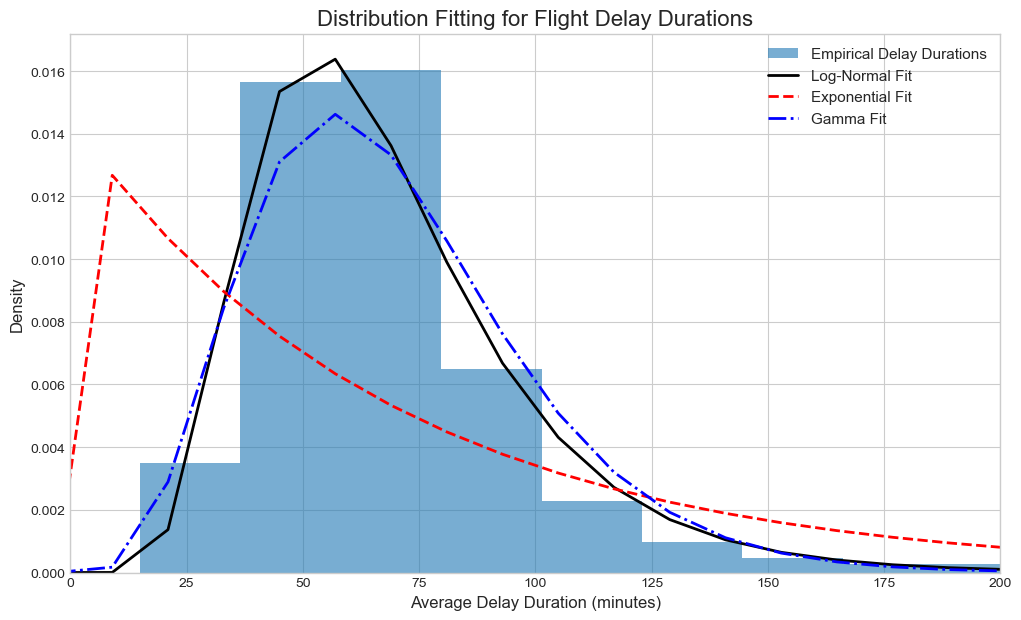

In [8]:
# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot histogram of the data
ax.hist(delay_samples, bins=50, density=True, alpha=0.6, label='Empirical Delay Durations')

# Plot the PDF of the fitted distributions
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_log = stats.lognorm.pdf(x, shape_log, loc_log, scale_log)
p_exp = stats.expon.pdf(x, loc_exp, scale_exp)
p_gam = stats.gamma.pdf(x, a_gam, loc_gam, scale_gam)

ax.plot(x, p_log, 'k', linewidth=2, label='Log-Normal Fit')
ax.plot(x, p_exp, 'r--', linewidth=2, label='Exponential Fit')
ax.plot(x, p_gam, 'b-.', linewidth=2, label='Gamma Fit')

ax.set_title('Distribution Fitting for Flight Delay Durations', fontsize=16)
ax.set_xlabel('Average Delay Duration (minutes)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend(fontsize=11)
plt.xlim(0, 200)
plt.show()